### General libraries being loaded

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os, time
import pandas as pd

# Our new Deep Learning imports
import tensorflow as tf
from tensorflow import keras

# To plot nice figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# For plotting statistical figures
import seaborn as sns; sns.set()

# For speeding up numpy operations
import cupy as cp

# For faster numpy computation
from numba import jit, cuda

# For Progress Bar
from tqdm.auto import tqdm,trange
tqdm.pandas()

# Vaex Dataframe library
import vaex as vx

# For Pyspark activation
import os
os.environ["PYARROW_IGNORE_TIMEZONE"] = "1"

# Pyspark Dataframe
from pyspark import pandas as ps

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

### Training and Testing Data Loading

In [2]:
quora_tt_df = pd.read_pickle(r"D:\UoA\Tri 2\Big Data Analysis and Projects\Week 1\Quora Insincere Questions\Data\Train and Test\quora_tt_df.pkl")
quora_tt_freq_df = pd.read_pickle(r"D:\UoA\Tri 2\Big Data Analysis and Projects\Week 1\Quora Insincere Questions\Data\Train and Test\quora_tt_freq_df.pkl")

In [3]:
import pickle

f = open(r"D:\UoA\Tri 2\Big Data Analysis and Projects\Week 1\Quora Insincere Questions\Data\Train and Test\quora_tt_dict_idf.pkl","rb")
f1 = open(r"D:\UoA\Tri 2\Big Data Analysis and Projects\Week 1\Quora Insincere Questions\Data\Train and Test\quora_tt_word_dict.pkl","rb")

quora_tt_dict_idf = pickle.load(f)
quora_tt_word_dict = pickle.load(f1)

f.close()
f1.close()

max_sentence_length_quora = np.load(r"D:\UoA\Tri 2\Big Data Analysis and Projects\Week 1\Quora Insincere Questions\Data\Train and Test\max_sentence_length_quora.npy")
max_sentence_length_quora = int(max_sentence_length_quora)

### Paragram Word Embedding Loading

In [4]:
paragram_embedding_matrix_tt = np.load(r"D:\UoA\Tri 2\Big Data Analysis and Projects\Week 1\Quora Insincere Questions\embeddings\paragram_300_sl999\paragram_embedding_matrix_tt.npy")

In [5]:
f = open(r"D:\UoA\Tri 2\Big Data Analysis and Projects\Week 1\Quora Insincere Questions\embeddings\paragram_300_sl999\paragram_embedding_matrix_tt_dict.pkl","rb")
paragram_embedding_matrix_tt_dict = pickle.load(f)
f.close()

### Basic imports for Model Execution

In [6]:
from keras.layers import Input,Embedding,SpatialDropout1D,Bidirectional,CuDNNLSTM,CuDNNGRU,GlobalMaxPooling1D,Concatenate,Dense,LSTM,GRU
from keras.optimizers import Adam
from keras.models import Model
from keras.initializers import Constant

from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_curve

from kneed import KneeLocator

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_fscore_support

### Creating a Deep Neural Network for Paragram Word Embedding

In [7]:
def quora_DNN_build_model(embedding_matrix_quora,max_sentence_length_quora,embedding_size_quora,number_words_quora,learning_rate_quora):
    inp = Input(shape=(max_sentence_length_quora,))
    x = Embedding(number_words_quora, embedding_size_quora, embeddings_initializer=Constant(embedding_matrix_quora), trainable=False)(inp)
    x = SpatialDropout1D(0.3)(x)
    x1 = Bidirectional(LSTM(256, return_sequences=True))(x)
    x2 = Bidirectional(GRU(128, return_sequences=True))(x1)
    max_pool1 = GlobalMaxPooling1D()(x1)
    max_pool2 = GlobalMaxPooling1D()(x2)
    conc = Concatenate()([max_pool1, max_pool2])
    predictions = Dense(1, activation='sigmoid')(conc)
    model = Model(inputs=inp, outputs=predictions)
    adam = Adam(learning_rate=learning_rate_quora)
    model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [8]:
model_paragram = quora_DNN_build_model(embedding_matrix_quora=paragram_embedding_matrix_tt,max_sentence_length_quora=max_sentence_length_quora,
                             embedding_size_quora=300,number_words_quora=paragram_embedding_matrix_tt.shape[0],learning_rate_quora=0.001)

In [9]:
num_epoch = 4
batch_size = 256

In [10]:
quora_train_features_array_paragram = np.copy(np.array(quora_tt_df.loc[~(quora_tt_df['target'] == -1),'question_text_encode'].to_list(),dtype=np.float64))
quora_train_pridiction_array_paragram = np.copy(np.array(quora_tt_df.loc[~(quora_tt_df['target'] == -1),'target'].to_list(),dtype=np.float64))
paragram_history = model_paragram.fit(quora_train_features_array_paragram, quora_train_pridiction_array_paragram, validation_split=0.2, batch_size=batch_size, validation_batch_size=batch_size, epochs=num_epoch-1, verbose=1, shuffle=True, use_multiprocessing=True)

Epoch 1/3
4082/4082 [==============================] - 742s 179ms/step - loss: 0.1329 - accuracy: 0.9499 - val_loss: 0.1180 - val_accuracy: 0.9540
Epoch 2/3
4082/4082 [==============================] - 730s 179ms/step - loss: 0.1154 - accuracy: 0.9552 - val_loss: 0.1136 - val_accuracy: 0.9554
Epoch 3/3
4082/4082 [==============================] - 730s 179ms/step - loss: 0.1083 - accuracy: 0.9577 - val_loss: 0.1146 - val_accuracy: 0.9543


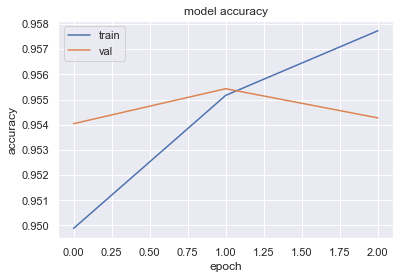

In [11]:
# Accuracy Plot
plt.plot(paragram_history.history['accuracy'])
plt.plot(paragram_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

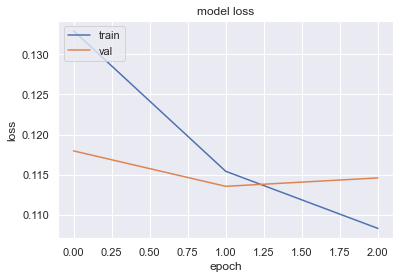

In [12]:
# Loss plot
plt.plot(paragram_history.history['loss'])
plt.plot(paragram_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [13]:
quora_train_pridicted_array_paragram = model_paragram.predict(quora_train_features_array_paragram, batch_size=batch_size, verbose=1, use_multiprocessing=True)
quora_train_pridicted_array_paragram = np.squeeze(quora_train_pridicted_array_paragram)
quora_train_pridicted_array_paragram_copy = np.copy(quora_train_pridicted_array_paragram)

5103/5103 [==============================] - 297s 58ms/step


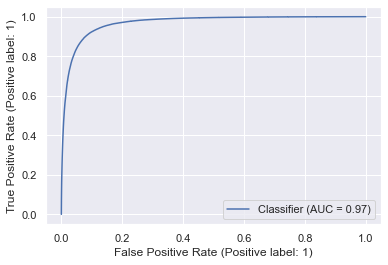

In [14]:
RocCurveDisplay.from_predictions(quora_train_pridiction_array_paragram, quora_train_pridicted_array_paragram)
plt.show()
fpr_paragram, tpr_paragram, thresholds_paragram = roc_curve(quora_train_pridiction_array_paragram, quora_train_pridicted_array_paragram)

The Knee point of ROC Curve (x-axis) is:

0.020022655454284298


The Knee point of ROC Curve (y-axis) is:

0.6727013983417894




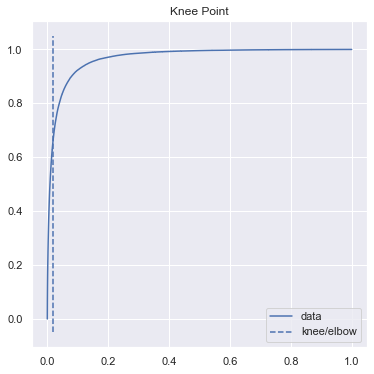

In [15]:
kn_paragram = KneeLocator(fpr_paragram, tpr_paragram, curve='concave', direction='increasing')
print('\033[1m' + 'The Knee point of ROC Curve (x-axis) is:' + '\033[0m' + '\n')
print(kn_paragram.knee)
print('\n')
print('\033[1m' + 'The Knee point of ROC Curve (y-axis) is:' + '\033[0m' + '\n')
print(kn_paragram.knee_y)
print('\n')
kn_paragram.plot_knee()

In [16]:
point_x_index_paragram = np.where(fpr_paragram == kn_paragram.knee)
point_y_index_paragram = np.where(tpr_paragram == kn_paragram.knee_y)
threshold_index_paragram = np.intersect1d(point_x_index_paragram, point_y_index_paragram)
threshold_value_paragram = thresholds_paragram[threshold_index_paragram[0]]

In [17]:
quora_train_pridicted_array_paragram[quora_train_pridicted_array_paragram <= threshold_value_paragram] = 0
quora_train_pridicted_array_paragram[quora_train_pridicted_array_paragram > threshold_value_paragram] = 1

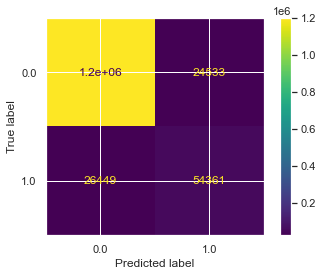

The Precision (Paragram) is:

0.9605423467140443


The Recall (Paragram) is:

0.9609668928323694


The F-Score (Paragram) is:

0.9607479958714674




In [18]:
tn_paragram, fp_paragram, fn_paragram, tp_paragram = confusion_matrix(quora_train_pridiction_array_paragram,quora_train_pridicted_array_paragram).ravel()
ConfusionMatrixDisplay.from_predictions(quora_train_pridiction_array_paragram,quora_train_pridicted_array_paragram)
plt.show()

precision_paragram, recall_paragram, fbeta_score_paragram, support_paragram = precision_recall_fscore_support(quora_train_pridiction_array_paragram,quora_train_pridicted_array_paragram, average='weighted')
print('\033[1m' + 'The Precision (Paragram) is:' + '\033[0m' + '\n')
print(precision_paragram)
print('\n')
print('\033[1m' + 'The Recall (Paragram) is:' + '\033[0m' + '\n')
print(recall_paragram)
print('\n')
print('\033[1m' + 'The F-Score (Paragram) is:' + '\033[0m' + '\n')
print(fbeta_score_paragram)
print('\n')

In [19]:
quora_test_features_array_paragram = np.copy(np.array(quora_tt_df.loc[(quora_tt_df['target'] == -1),'question_text_encode'].to_list(),dtype=np.float64))
quora_test_pridicted_array_paragram = model_paragram.predict(quora_test_features_array_paragram, batch_size=batch_size, verbose=1, use_multiprocessing=True)
quora_test_pridicted_array_paragram = np.squeeze(quora_test_pridicted_array_paragram)

1468/1468 [==============================] - 86s 59ms/step


In [20]:
import tensorflow as tf
tf.keras.backend.clear_session()

In [21]:
del paragram_embedding_matrix_tt
del quora_train_features_array_paragram
del quora_train_pridiction_array_paragram
del model_paragram

In [22]:
import gc
gc.collect()
print('',end='')

In [23]:
np.save(r"D:\UoA\Tri 2\Big Data Analysis and Projects\Week 1\Quora Insincere Questions\embeddings\paragram_300_sl999\quora_test_pridicted_array_paragram.npy",quora_test_pridicted_array_paragram)

In [24]:
del quora_test_pridicted_array_paragram

In [25]:
np.save(r"D:\UoA\Tri 2\Big Data Analysis and Projects\Week 1\Quora Insincere Questions\embeddings\paragram_300_sl999\quora_train_pridicted_array_paragram.npy",quora_train_pridicted_array_paragram_copy)

In [26]:
del quora_train_pridicted_array_paragram
del quora_train_pridicted_array_paragram_copy

In [27]:
np.save(r"D:\UoA\Tri 2\Big Data Analysis and Projects\Week 1\Quora Insincere Questions\embeddings\paragram_300_sl999\threshold_value_paragram.npy",threshold_value_paragram)